In [186]:
#!/usr/bin/env python
# encoding: utf-8

import tweepy #https://github.com/tweepy/tweepy
import csv

#Twitter API credentials
consumer_key = "***"
consumer_secret = "***"
access_key = "***"
access_secret = "***"

a_tweets = []

def get_all_tweets(screen_name):
    #Twitter only allows access to a users most recent 3240 tweets with this method

    #authorize twitter, initialize tweepy
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_key, access_secret)
    api = tweepy.API(auth)

    #initialize a list to hold all the tweepy Tweets
    alltweets = []

    #make initial request for most recent tweets (200 is the maximum allowed count)
    new_tweets = api.user_timeline(screen_name = screen_name,count=200)

    #save most recent tweets
    alltweets.extend(new_tweets)

    #save the id of the oldest tweet less one
    oldest = alltweets[-1].id - 1

    #keep grabbing tweets until there are no tweets left to grab
    while len(new_tweets) > 0:
        print "getting tweets before %s" % (oldest)

        #all subsiquent requests use the max_id param to prevent duplicates
        new_tweets = api.user_timeline(screen_name = screen_name,count=200,max_id=oldest)

        #save most recent tweets
        alltweets.extend(new_tweets)

        #update the id of the oldest tweet less one
        oldest = alltweets[-1].id - 1

        print "...%s tweets downloaded so far" % (len(alltweets))

    #transform the tweepy tweets into a 2D array that will populate the csv	
    outtweets = [[tweet.id_str, tweet.created_at, tweet.text.encode("utf-8")] for tweet in alltweets]

    #write the csv	
    with open('%s_tweets.csv' % screen_name, 'wb') as f:
        writer = csv.writer(f)
        writer.writerow(["id","created_at","text"])
        writer.writerows(outtweets)
    
    a_tweet = alltweets


if __name__ == '__main__':
    pass

    #pass in the username of the account you want to download
    #get_all_tweets("realDonaldTrump")

In [4]:
import pandas as pd
import io
import requests
url='https://raw.githubusercontent.com/jbelluche/testrepo/master/TrumpNov29Json.txt'
c=pd.read_json(url)

In [5]:
c.head()

,created_at,id_str,is_retweet,source,text
0,2018-11-29 12:32:13,1068120444279103488,False,Twitter for iPhone,Billions of Dollars are pouring into the coffe...
1,2018-11-29 12:16:12,1068116413498429440,False,Twitter for iPhone,When will this illegal Joseph McCarthy style W...
2,2018-11-29 11:54:16,1068110895409233920,False,Twitter for iPhone,Did you ever see an investigation more in sear...
3,2018-11-29 11:37:14,1068106609644183552,False,Twitter for iPhone,General Motors is very counter to what other a...
4,2018-11-29 04:39:03,1068001369746022400,False,Twitter for iPhone,So much happening with the now discredited Wit...


In [3]:
# stopwords are the words to be ignored in the tweet
import nltk
stopwords = nltk.corpus.stopwords.words("english")

In [7]:
a = c.iloc[6]
print a
print a['text']

created_at                                  2018-11-28 23:32:11
id_str                                      1067924142316494848
is_retweet                                                False
source                                       Twitter for iPhone
text          On behalf of @FLOTUS Melania and the entire Tr...
Name: 6, dtype: object
On behalf of @FLOTUS Melania and the entire Trump family, I want to wish you all a very MERRY CHRISTMAS! May this Christmas Season bring peace to your hearts, warmth to your homes, cheer to your spirits and JOY TO THE WORLD! #NCTL2018🎄 https://t.co/XNMJQ5JDSU


In [8]:
# used to get a sentiment score from the tweet
from afinn import Afinn
afinn = Afinn()

In [9]:
# 
text = a['text']
cleanwords = []
for word in text.split():
    if word in stopwords:
        continue
    if word.find('https://') >= 0 or word.find('http://') >= 0:
        continue
    cleanwords.append(word.lower())
print(cleanwords)

[u'on', u'behalf', u'@flotus', u'melania', u'entire', u'trump', u'family,', u'i', u'want', u'wish', u'merry', u'christmas!', u'may', u'christmas', u'season', u'bring', u'peace', u'hearts,', u'warmth', u'homes,', u'cheer', u'spirits', u'joy', u'to', u'the', u'world!', u'#nctl2018\U0001f384']


In [10]:
print afinn.score(' '.join(cleanwords))/len(cleanwords)

0.518518518519


In [11]:
def calculate_sentiment(text, afinn):
    cleanwords = []
    try:
        for word in text.split():
            if word in stopwords:
                continue
            if word.find('https://') >= 0 or word.find('http://') >= 0:
                continue
            cleanwords.append(word.lower())
    #     print(cleanwords)
        if len(cleanwords) == 0:
            return 0.0
        score = afinn.score(' '.join(cleanwords))
        return score/float(len(cleanwords))
    except Exception as e:
        return 'NaN'

In [12]:
def sentiment_scores_df(num_tweets, df, afinn):
    sentiment_scores = []
    if num_tweets == 'all':
        num_tweets = len(df)
    for i, row in c.iterrows():
        if i > num_tweets:
            break
        tweet = row['text']
        score = calculate_sentiment(tweet, afinn)
        if score != 'NaN':
            score = float("{0:.4f}".format(score))
        sentiment_scores.append(score)
    return sentiment_scores

In [205]:
df = c.copy()

In [200]:
sscores = sentiment_scores_df('all', df, afinn)

In [209]:
df = df.assign(sent_score=sscores)
df.head()

,created_at,id_str,is_retweet,source,text,sent_score
0,2018-11-29 12:32:13,1068120444279103488,False,Twitter for iPhone,Billions of Dollars are pouring into the coffe...,-0.1154
1,2018-11-29 12:16:12,1068116413498429440,False,Twitter for iPhone,When will this illegal Joseph McCarthy style W...,-0.3793
2,2018-11-29 11:54:16,1068110895409233920,False,Twitter for iPhone,Did you ever see an investigation more in sear...,-0.5769
3,2018-11-29 11:37:14,1068106609644183552,False,Twitter for iPhone,General Motors is very counter to what other a...,0.0385
4,2018-11-29 04:39:03,1068001369746022400,False,Twitter for iPhone,So much happening with the now discredited Wit...,-0.3636


In [210]:
df.to_csv('TrumpNov29WithSScore.csv', encoding='utf-8')

In [ ]:
# try using deepmoji

In [14]:
df = pd.read_csv('TrumpNov29WithSScore.csv')

In [15]:
df.head()

,created_at,id_str,is_retweet,source,text,sent_score
0,11/29/18 12:32,1.068120e+18,False,Twitter for iPhone,Billions of Dollars are pouring into the coffe...,-0.1154
1,11/29/18 12:16,1.068120e+18,False,Twitter for iPhone,When will this illegal Joseph McCarthy style W...,-0.3793
2,11/29/18 11:54,1.068110e+18,False,Twitter for iPhone,Did you ever see an investigation more in sear...,-0.5769
3,11/29/18 11:37,1.068110e+18,False,Twitter for iPhone,General Motors is very counter to what other a...,0.0385
4,11/29/18 4:39,1.068000e+18,False,Twitter for iPhone,So much happening with the now discredited Wit...,-0.3636


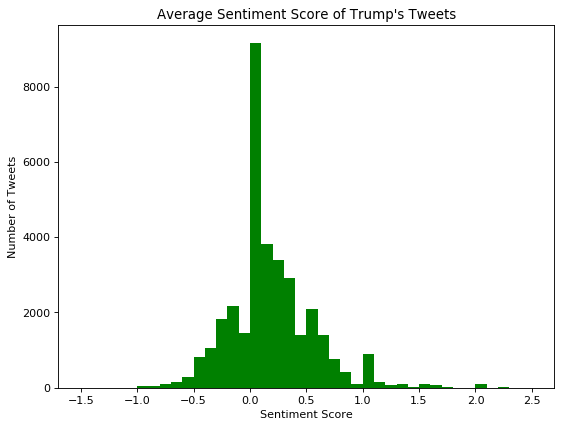

In [57]:
import matplotlib.pyplot as plt
df.dropna()
x = df['sent_score']
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.hist(list(x)[:len(x)-1000], 40, (x.min()+1.5, x.max()-1.5), color='g')
plt.title("Average Sentiment Score of Trump's Tweets")
plt.ylabel("Number of Tweets")
plt.xlabel("Sentiment Score")
plt.show()

In [86]:
times = []
for i, row in df.iterrows():
    try:
        time = pd.Timestamp(row['created_at'])
        times.append(time.hour)
    except Exception as e:
        print(row['created_at'])

0
0
-0.2


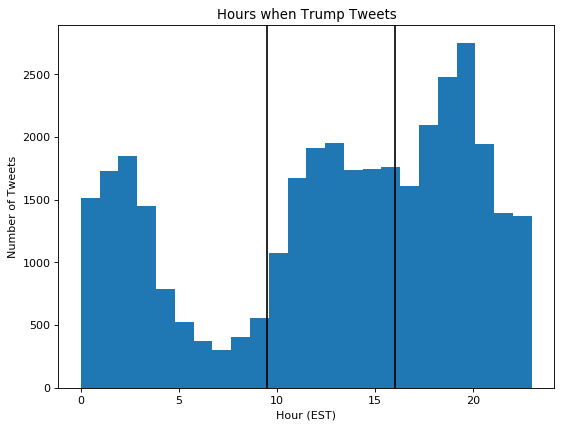

In [123]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.hist(times[:len(times)-1000], 24)
plt.title("Hours when Trump Tweets")
plt.xlabel("Hour (EST)")
plt.ylabel("Number of Tweets")
plt.axvline(x=9.5, color='black')
plt.axvline(x=16, color='black')
plt.show()

In [121]:
daysofweek = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
days = []
for i, row in df.iterrows():
    try:
        day = pd.Timestamp(row['created_at'])
        days.append(daysofweek[day.dayofweek])
    except Exception as e:
        print(i,row['created_at'])

(35473, '0')
(35597, '0')
(35621, nan)
(35622, nan)
(35623, nan)
(35624, nan)
(35625, '-0.2')


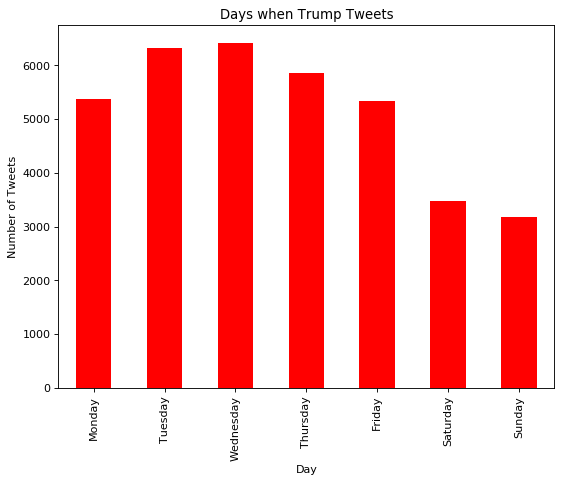

In [122]:
DAYS = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
pd.Series(days).value_counts().reindex(DAYS, fill_value=0).plot.bar(color='red')
plt.title("Days when Trump Tweets")
plt.xlabel("Day")
plt.ylabel("Number of Tweets")
plt.show()

In [125]:
from wordcloud import WordCloud, STOPWORDS

In [182]:
words = []
for i, row in df.iterrows():
#     if i > 1000:
#         break
    
    try:
        if row['is_retweet']:
            continue
        words.extend(row['text'].split())
    except Exception as e:
        print(i, row['text'])
    
    
for i in range(len(words)):
    words[i] = words[i].translate(None, ".$!,/?-%").lower()


In [183]:
stringofwords = ' '.join(words)

In [184]:
stopwords = set(STOPWORDS)
stopwords.add('https')
stopwords.add('rt')
stopwords.add('realdonaldtrump')
stopwords.add('amp')

wc = WordCloud(max_words=1000, stopwords=stopwords, margin=10,random_state=1).generate(stringofwords)

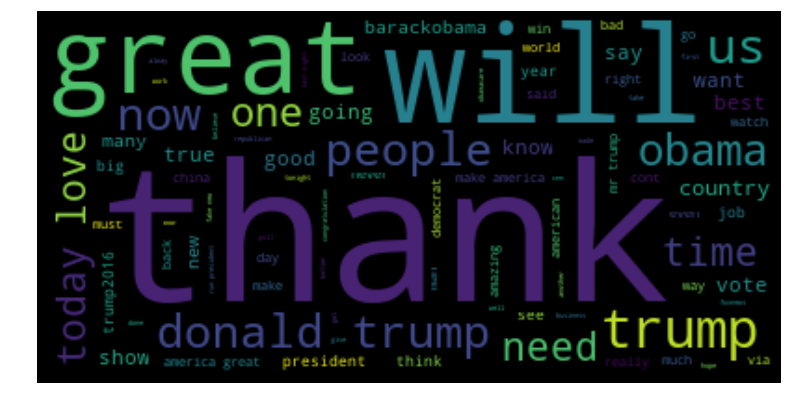

In [185]:
default_colors = wc.to_array()
plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(default_colors, interpolation="bilinear")
plt.axis("off")
plt.show()

In [197]:
emoj = pd.read_csv('test_sentences.csv')

In [199]:
emoj.head()

,Text,Top5%,Emoji_1,Emoji_2,Emoji_3,Emoji_4,Emoji_5,Pct_1,Pct_2,Pct_3,Pct_4,Pct_5
0,Billions of Dollars are pouring into the coffe...,0.290665,32,55,33,62,25,0.100459,0.071994,0.042611,0.038831,0.036771
1,When will this illegal Joseph McCarthy style W...,0.425414,32,46,55,34,27,0.105558,0.103549,0.080169,0.077162,0.058977
2,Did you ever see an investigation more in sear...,0.427425,32,55,12,41,25,0.157205,0.103903,0.064565,0.056425,0.045328
3,General Motors is very counter to what other a...,0.403117,32,55,19,25,37,0.129634,0.109936,0.073316,0.051891,0.038339
4,So much happening with the now discredited Wit...,0.292888,12,62,32,52,43,0.065822,0.065414,0.056404,0.055462,0.049786


In [259]:
def get_most_used_emoji(df, partitions):
    top = []
    l = int(len(df)/partitions)
    start = 0
    for i in range(partitions):
        p = df.iloc[start:(i+1)*l]
        t = p['Emoji_1'].value_counts()
        top.append(t)
        start = (i+1)*l
        
    return top

most = get_most_used_emoji(emoj, 100)
print(len(most))

100


In [209]:
loc = None
for i, row in emoj.iterrows():
    if row['Text'].find('Such a beautiful and important evening!') >= 0:
        loc = i
        break

In [228]:
emoj_after = emoj.iloc[:loc+1]
emoj_before = emoj.iloc[loc+1:]

In [263]:
s1 = emoj_before['Emoji_1'].value_counts()[:10]
s2 = emoj_after['Emoji_1'].value_counts()[:10]

In [286]:
# most common emojis after becoming president
s1k = s1.keys()
s1v = [s1[v] for v in s1k]
print(s1k)
print(s1v)
# plt.bar(s1k, s1v)

Int64Index([33, 32, 40, 57, 50, 7, 21, 12, 0, 41], dtype='int64')
[10034, 3216, 2029, 1246, 897, 886, 829, 720, 706, 666]


In [288]:
# most common emojis after becoming president
s2k = s2.keys()
s2v = [s2[v] for v in s2k]
print(s2k)
print(s2v)

Int64Index([33, 32, 57, 40, 61, 21, 22, 34, 12, 44], dtype='int64')
[1449, 1157, 282, 277, 276, 263, 196, 118, 82, 72]
